In [28]:
import pandas as pd
import nltk
import torch.nn as nn
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec



In [76]:

# Replace 'your_file.csv' with the actual path to your CSV file
file_path = '15topics_en.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [77]:
df.head()

,topic,hashtag,content,hashtag_related 1,hashtag_related 2,hashtag_related 3,hashtag_related 4,hashtag_related 5,author,create_at
0,Politics,Politics,mike levin from ca49 is a clean energy adv...,#CA49,NaN,NaN,NaN,NaN,BeckyWerner,2023-11-14 16:54:43+00:00
1,Politics,Politics,rewiring america will have an educational ...,NaN,NaN,NaN,NaN,NaN,BeckyWerner,2023-11-14 16:47:34+00:00
2,Politics,Politics,vote to re elect president joe biden he won ...,#USpol,#USpolitics,#politics,#fascism,NaN,danwentzel,2023-11-14 16:45:55+00:00
3,Politics,Politics,christianity comes with privileges denied thos...,#SpeakerJohnson,#churchandstate,#politics,#ChristianNationalism,#privilege,JaniceSelbie,2023-11-14 16:37:26+00:00
4,Politics,Politics,life comes at you fast when you re a populist...,#populism,#ukpolitics,#politics,NaN,NaN,mattlav1250,2023-11-14 16:36:26+00:00


In [78]:
contents = df['content'].tolist()

In [79]:
df['topic'].value_counts()

Travel             195
Education          194
Health             193
Science            191
Environment        191
Humor              185
Politics           183
Entertainment      180
Technology         173
Sports             172
Lifestyle          165
Fashion            163
Art and Culture    159
News               145
Food               122
Name: topic, dtype: int64

In [33]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
texts = contents
labels = df['topic'].tolist()
# Preprocess texts
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

texts = [preprocess(text) for text in texts]

## Pre-trained word2vec model

In [90]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [262]:
word2vec_google_news = gensim.downloader.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-25')


In [266]:
len(word2vec_google_news['test'])

300

In [267]:
vector_size = 300

# Preprocess texts
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

texts = [preprocess(text) for text in texts]

# Train Word2Vec or load a pre-trained model
# model = Word2Vec.load("path_to_pretrained_model")  # If using a pre-trained model
model = word2vec_google_news
# Vectorize sentences
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = []
    for word in words:
        try:
            word_vectors.append(model[word])
        except KeyError:
            pass
    # word_vectors = [model[word] for word in words if model.key_to_index[word]]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)



## Don't use the pre-trained word2vec model

In [ ]:

vector_size = 32
texts = contents



# Train Word2Vec or load a pre-trained model
model = Word2Vec([text.split() for text in texts], vector_size=vector_size, window=5, min_count=1, workers=4)
# model = Word2Vec.load("path_to_pretrained_model")  # If using a pre-trained model
# Vectorize sentences
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)



In [264]:
X = np.array([sentence_vector(text, model) for text in texts])

# Prepare labels
labels = df['topic'].tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [276]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.layer3(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 32
mlp = MLP(input_size, hidden_size, 15)  # Adjust input_size and hidden_size as per your data


In [277]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

def train(epochs, train_loader, test_loader, mlp, criteria, optimizer):
    train_losses = []
    test_losses = []
    train_precisions = []
    test_precisions = []


    for epoch in range(epochs):
        loss_train = 0
        precision_train = 0
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.float()
            outputs = mlp(data)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            precision_train += (outputs.argmax(dim=1) == labels).float().mean()
        loss_train /= len(train_loader)
        precision_train /= len(train_loader)

        loss_test = 0
        precision_test = 0
        with torch.no_grad():  # No gradient calculation in evaluation
            for i, (data, labels) in enumerate(test_loader):
                data = data.float()
                outputs = mlp(data)
                loss = criteria(outputs, labels)
                loss_test += loss.item()
                precision_test += (outputs.argmax(dim=1) == labels).float().mean()
        loss_test /= len(test_loader)
        precision_test /= len(test_loader)
        print(f'Epoch {epoch+1}: train loss: {loss_train}, train precision: {precision_train} test loss: {loss_test}, test precision: {precision_test}')
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
    return train_losses, test_losses, train_precisions, test_precisions

In [278]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

train_losses, test_losses, train_precisions, test_precisions = train(500, train_loader, test_loader, mlp, criteria, optimizer)

Epoch 1: train loss: 2.399435057784572, train precision: 0.2568182051181793 test loss: 1.7722829182942708, test precision: 0.4431818425655365
Epoch 2: train loss: 1.3917982957579873, train precision: 0.5681818127632141 test loss: 1.2881098058488634, test precision: 0.6054292917251587
Epoch 3: train loss: 1.0041811249472878, train precision: 0.7047348618507385 test loss: 1.116304079691569, test precision: 0.6412563323974609
Epoch 4: train loss: 0.8684644048864191, train precision: 0.7445076107978821 test loss: 1.1562698152330186, test precision: 0.6418876051902771
Epoch 5: train loss: 0.732239126256018, train precision: 0.781818151473999 test loss: 1.0061440666516621, test precision: 0.7002841234207153
Epoch 6: train loss: 0.6434962939132344, train precision: 0.8203598260879517 test loss: 0.9435788657930162, test precision: 0.7159091234207153
Epoch 7: train loss: 0.5766945869633646, train precision: 0.8318182229995728 test loss: 0.9012219044897292, test precision: 0.7364267706871033
Epo

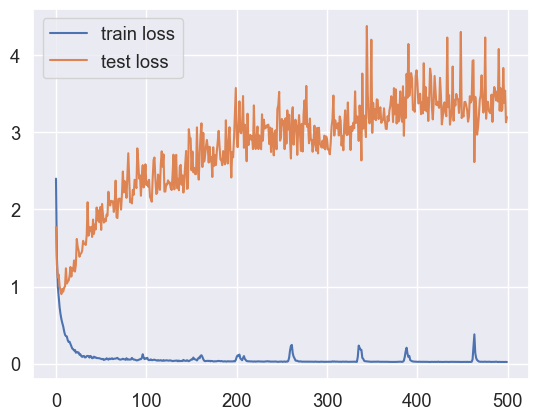

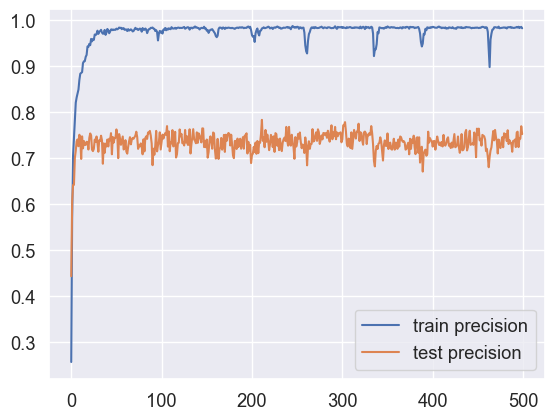

In [279]:
# Plot losses and precisions
import matplotlib.pyplot as plt

def affichage(train_losses, test_losses, train_precisions, test_precisions):
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.savefig('loss_original.png')
    plt.show()
    plt.plot(train_precisions, label='train precision')
    plt.plot(test_precisions, label='test precision')
    plt.legend()
    plt.savefig('precision_original.png')
    plt.show()
affichage(train_losses, test_losses, train_precisions, test_precisions)



In [303]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out = self.norm(x)
        out = self.layer1(x)
        out = self.relu1(out)
        # out = self.dropout(out)
        out = self.layer2(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 32


Epoch 1: train loss: 2.7074105631221426, train precision: 0.05350378900766373 test loss: 2.705418488558601, test precision: 0.06584224849939346
Epoch 2: train loss: 2.695580598079797, train precision: 0.06344696879386902 test loss: 2.69338724192451, test precision: 0.08806818723678589
Epoch 3: train loss: 2.6800142634998667, train precision: 0.1358901560306549 test loss: 2.6770242662990795, test precision: 0.14872993528842926
Epoch 4: train loss: 2.6608887152238325, train precision: 0.1827651560306549 test loss: 2.655736404306748, test precision: 0.2037099003791809
Epoch 5: train loss: 2.6370413339499272, train precision: 0.25189393758773804 test loss: 2.63029987671796, test precision: 0.2921122908592224
Epoch 6: train loss: 2.60881147962628, train precision: 0.3499053120613098 test loss: 2.6017758004805622, test precision: 0.3484291434288025
Epoch 7: train loss: 2.5787790218989053, train precision: 0.37784090638160706 test loss: 2.569473420872408, test precision: 0.3796791434288025
Ep

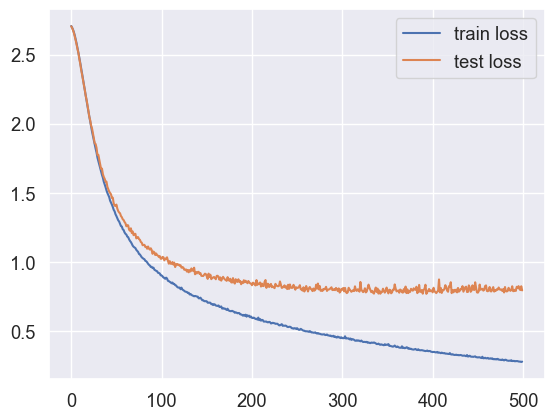

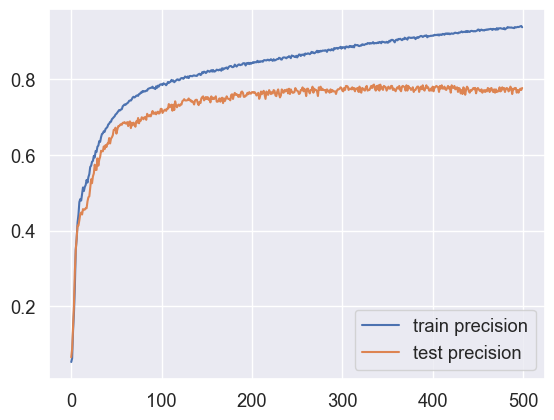

In [304]:
mlp = MLP(input_size, hidden_size, 15)  # Adjust input_size and hidden_size as per your data

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.00015)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

train_losses, test_losses, train_precisions, test_precisions = train(500, train_loader, test_loader, mlp, criteria, optimizer)

plt.figure()
affichage(train_losses, test_losses, train_precisions, test_precisions)

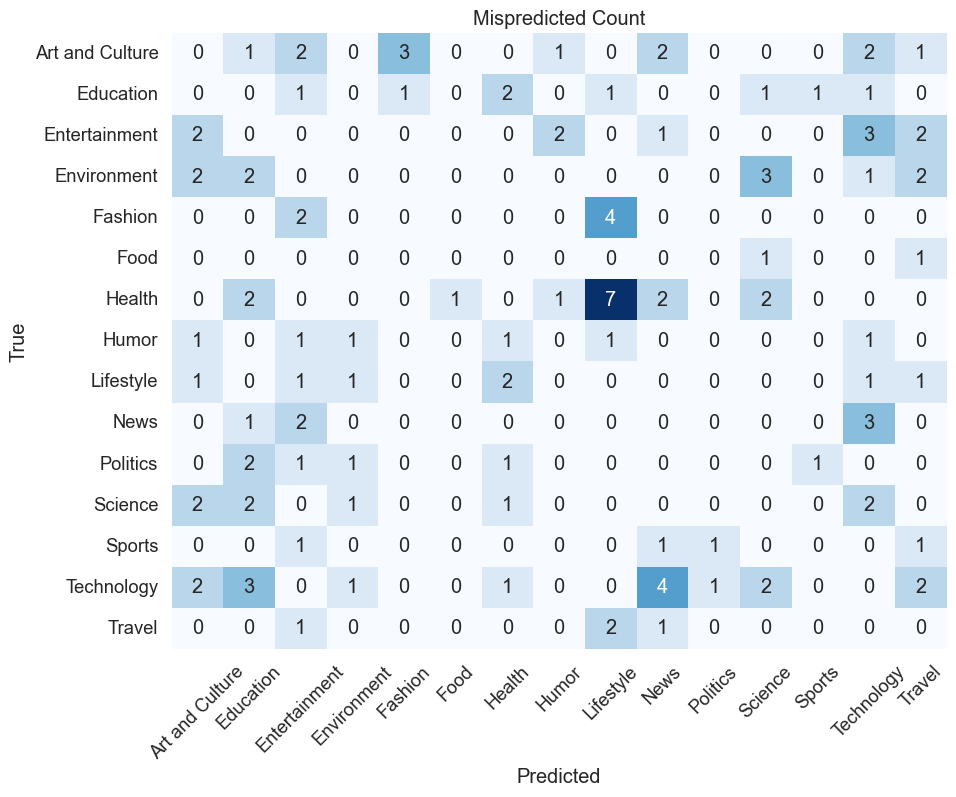

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("MLP Mispredicted")
plt.show()


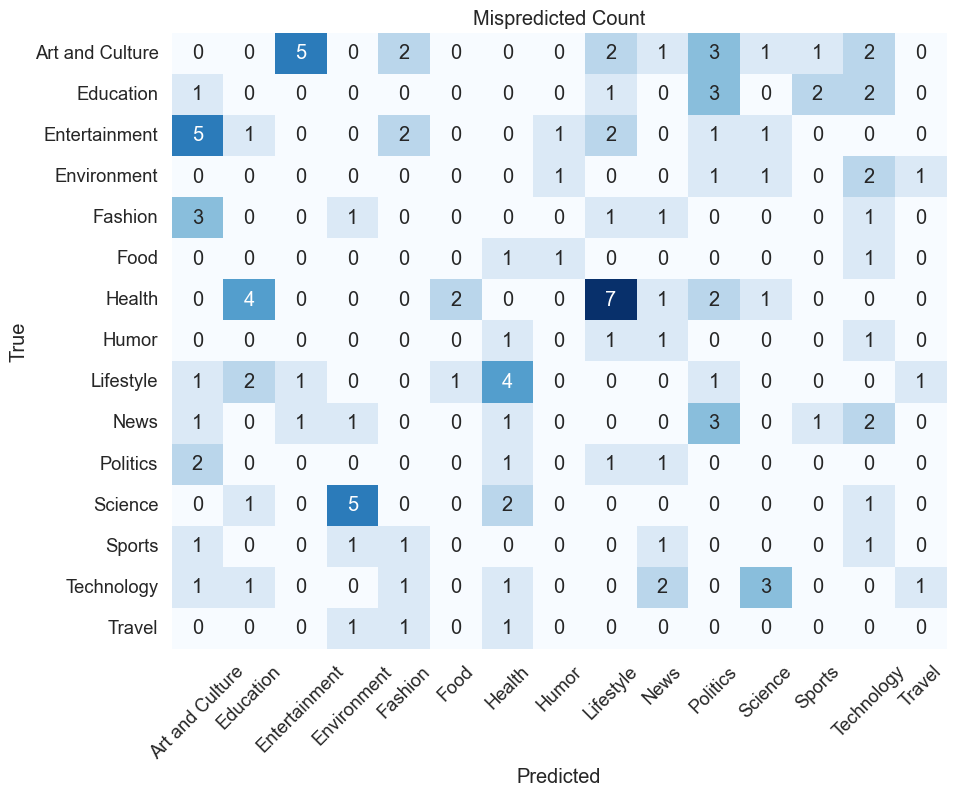

In [306]:
conf_matrix = confusion_matrix(y_train, mlp(torch.tensor(X_train).float()).argmax(dim=1).numpy())
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("MLP Train Mispredicted")
plt.show()

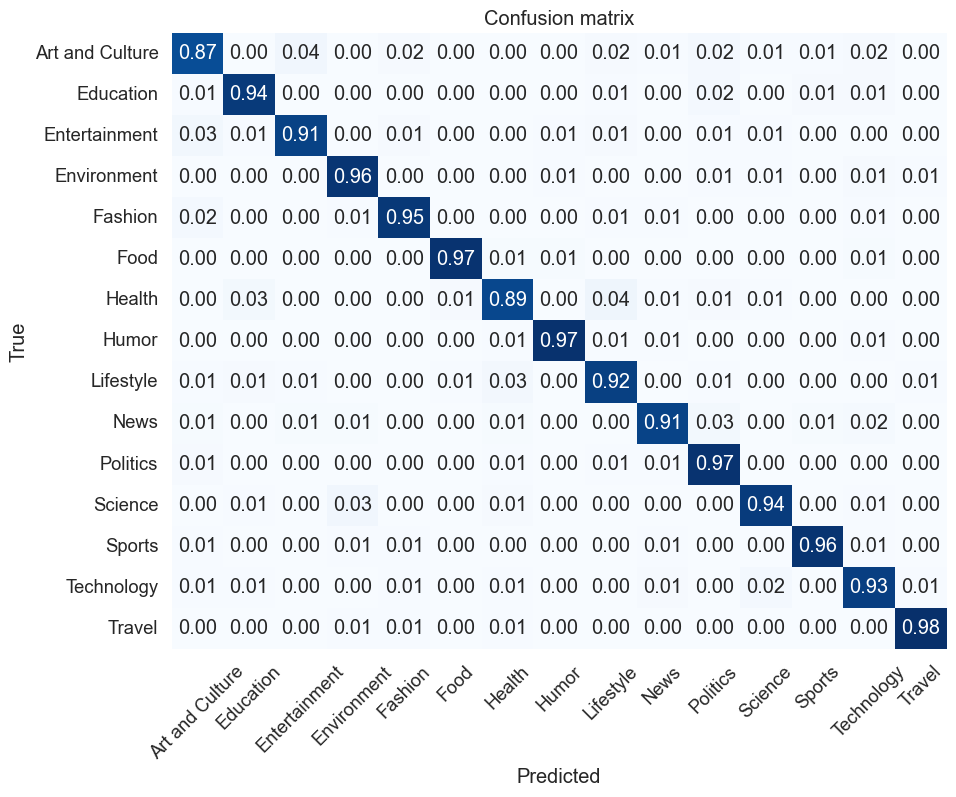

In [308]:
conf_matrix = confusion_matrix(y_train, mlp(torch.tensor(X_train).float()).argmax(dim=1).numpy())

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.xticks(rotation=45)
plt.savefig("Train MLP CM")
plt.show()

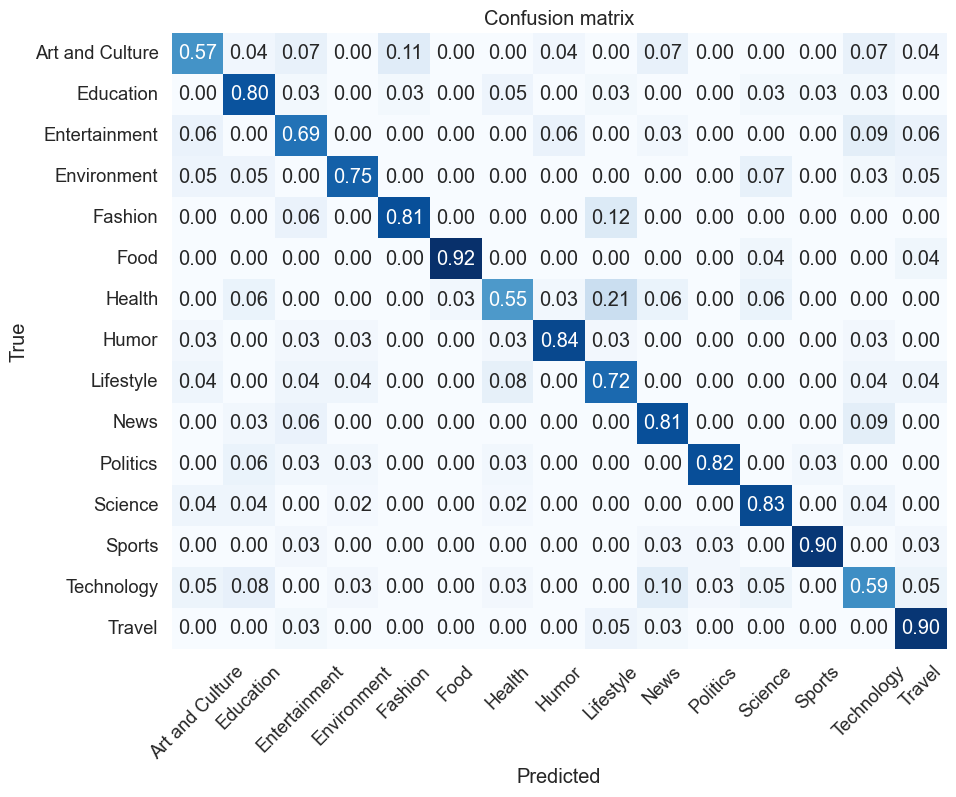

In [309]:
conf_matrix = confusion_matrix(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.xticks(rotation=45)
plt.savefig("Test MLP CM")
plt.show()

In [295]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Ensure num_classes matches the number of categories

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        return out

# Initialize MLP with the correct number of output classes
input_size = vector_size
hidden_size = 64
mlp = MLP(input_size, hidden_size, 15)  # Adjust input_size and hidden_size as per your data


In [181]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Epoch 1: train loss: 1.1529731244751902, train precision: 0.6306818127632141 test loss: 1.529999918407864, test precision: 0.5530303120613098
Epoch 2: train loss: 1.149085622845274, train precision: 0.6301136612892151 test loss: 1.6426733334859211, test precision: 0.5230429172515869
Epoch 3: train loss: 1.1445746927550344, train precision: 0.6303030252456665 test loss: 1.499376999007331, test precision: 0.5516098141670227
Epoch 4: train loss: 1.1742993177789631, train precision: 0.6135416626930237 test loss: 1.5961116817262437, test precision: 0.5429292917251587
Epoch 5: train loss: 1.151215049353513, train precision: 0.6221590638160706 test loss: 1.6184819009568956, test precision: 0.4970012903213501
Epoch 6: train loss: 1.1691569433067783, train precision: 0.6307764649391174 test loss: 1.513248364130656, test precision: 0.5776515007019043
Epoch 7: train loss: 1.1523576071768096, train precision: 0.6163825988769531 test loss: 1.5561737087037828, test precision: 0.5561869144439697
Epoc

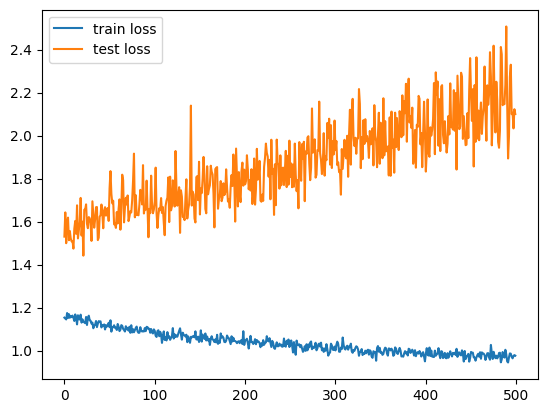

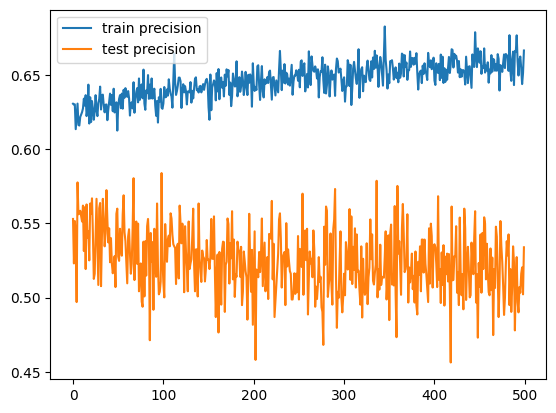

In [183]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

train_losses, test_losses, train_precisions, test_precisions = train(500, train_loader, test_loader, mlp, criteria, optimizer)
affichage(train_losses, test_losses, train_precisions, test_precisions)

Epoch 1: train loss: 2.7059274866380765, train precision: 0.06965649127960205 test loss: 2.6940160592397056, test precision: 0.07661845535039902
Epoch 2: train loss: 2.5811266990108344, train precision: 0.1531488597393036 test loss: 2.3198790405735825, test precision: 0.2620523273944855
Epoch 3: train loss: 2.011154363173565, train precision: 0.3721373975276947 test loss: 1.8075695940942476, test precision: 0.4344008266925812
Epoch 4: train loss: 1.5852300156163806, train precision: 0.5291030406951904 test loss: 1.4960845239234692, test precision: 0.5366735458374023
Epoch 5: train loss: 1.314788099008662, train precision: 0.6240457892417908 test loss: 1.277028714165543, test precision: 0.6224173307418823
Epoch 6: train loss: 1.1038283373563345, train precision: 0.6755725145339966 test loss: 1.173402558673512, test precision: 0.6520317196846008
Epoch 7: train loss: 0.9641145445008314, train precision: 0.7232824563980103 test loss: 1.0803835518432385, test precision: 0.663395345211029
Ep

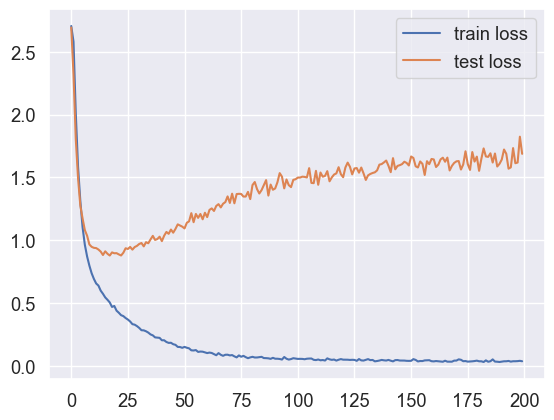

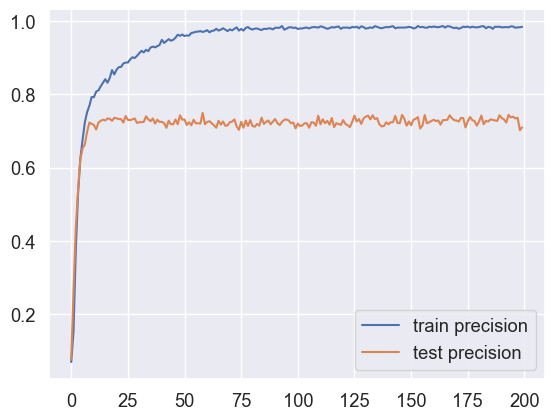

In [296]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
input_size = vector_size
hidden_size = 64
lstm = LSTM(input_size, hidden_size, 15)

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
train_losses, test_losses, train_precisions, test_precisions = train(200, train_loader, test_loader, lstm, criteria, optimizer)
affichage(train_losses, test_losses, train_precisions, test_precisions)

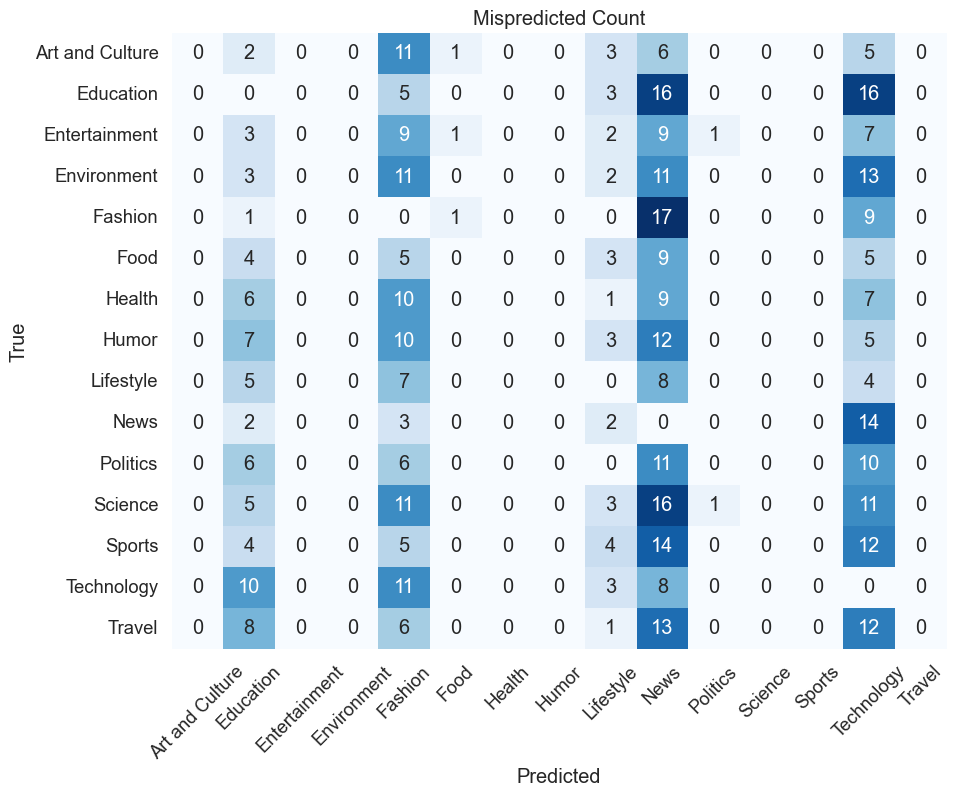

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, mlp(torch.tensor(X_test).float()).argmax(dim=1).numpy())
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("LSTM test Mispredicted")
plt.show()


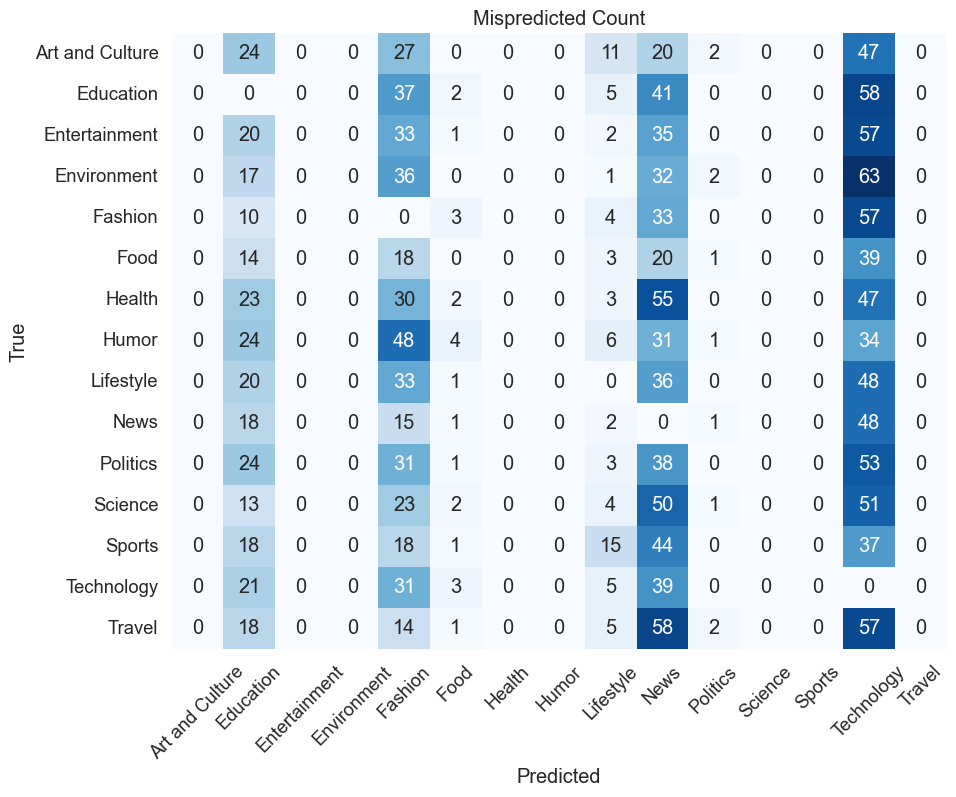

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_train, mlp(torch.tensor(X_train).float()).argmax(dim=1).numpy())
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("LSTM train Mispredicted")
plt.show()
